# **Desarrollar un clasificador CNN de dígitos manuscritos**

# **MNIST es un conjunto de datos para el uso en visión por computador. Se compone de una serie de dígitos manuscritos como los siguientes:**

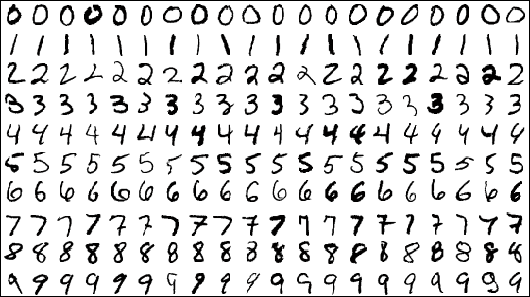

La base de datos de MNIST incluye también un conjunto de etiquetas para asociar cada dígito a una etiqueta correspondiente (0, 1, 2 ... 9). El objetivo principal del conjunto de datos es facilitar el reconocimiento de dígitos en imágenes.

**Importar librerias**

In [ ]:
from pathlib import Path
import requests
from keras.datasets import mnist
import torch 
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch, torchvision
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
torch.randn(5).cuda()

tensor([ 0.4290, -1.2699, -0.5276,  0.0181, -0.9714], device='cuda:0')

In [ ]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

In [ ]:
PATH.mkdir(parents=True, exist_ok=True)

**Descargar los datos de MNIST**

In [ ]:
URL = "http://storage.googleapis.com/tensorflow/tf-keras-dataset/mnist.npz/" 
FILENAME = "mnist.pkl.gz"

In [ ]:
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
  (x_train, y_train) , (x_valid, y_valid) = mnist.load_data("f")

x_train shape before:  (28, 28)
x_train shape after:  (28, 28)


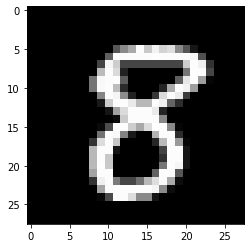

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

plt.close('all')
print('x_train shape before: ', x_train[90].shape)
plt.imshow(x_train[333].reshape((28, 28)), cmap="gray")
print('x_train shape after: ', x_train[90].shape)

In [4]:
import requests
from PIL import Image
from io import BytesIO

import copy

In [5]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

In [6]:
numb_batch = 64

In [ ]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

**Crear el Modelo**

In [8]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

**Validación del modelo**

In [9]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

**Función de entrenamiento**

In [10]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

**GPU Availability**

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

**Entrenamiento del modelo**

Saving Best Model with Accuracy:  95.43000030517578
Epoch: 1 Accuracy : 95.43000030517578 %
Saving Best Model with Accuracy:  97.05000305175781
Epoch: 2 Accuracy : 97.05000305175781 %
Saving Best Model with Accuracy:  97.19999694824219
Epoch: 3 Accuracy : 97.19999694824219 %
Saving Best Model with Accuracy:  97.55999755859375
Epoch: 4 Accuracy : 97.55999755859375 %
Saving Best Model with Accuracy:  97.93000030517578
Epoch: 5 Accuracy : 97.93000030517578 %
Epoch: 6 Accuracy : 97.81999969482422 %
Saving Best Model with Accuracy:  98.37000274658203
Epoch: 7 Accuracy : 98.37000274658203 %
Saving Best Model with Accuracy:  98.45999908447266
Epoch: 8 Accuracy : 98.45999908447266 %
Epoch: 9 Accuracy : 98.43000030517578 %
Saving Best Model with Accuracy:  98.55999755859375
Epoch: 10 Accuracy : 98.55999755859375 %
Epoch: 11 Accuracy : 98.55999755859375 %
Epoch: 12 Accuracy : 98.55999755859375 %
Epoch: 13 Accuracy : 98.51000213623047 %
Epoch: 14 Accuracy : 98.38999938964844 %
Saving Best Model w

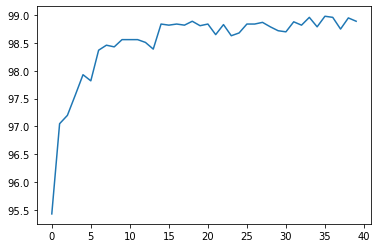

In [12]:
lenet = train(40, device=device)

**Guardar el modelo**

In [12]:
lenet = create_lenet().to(device)
lenet.load_state_dict(torch.load("lenet.pth"))
lenet.eval()

**Creación de la función para probar los datos de validación**

In [13]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [16]:
y_pred, y_true = predict_dl(lenet, val_dl)

**Matriz de confusión**

In [17]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,977,1,0,0,0,0,1,0,0,1
1,0,1134,0,0,0,0,1,0,0,0
2,2,1,1024,0,0,0,0,4,1,0
3,0,0,1,998,0,3,0,1,1,6
4,0,0,0,0,976,0,0,0,0,6
5,1,0,0,8,0,882,1,0,0,0
6,3,2,0,0,3,7,943,0,0,0
7,0,3,2,1,0,0,0,1015,1,6
8,2,1,3,2,2,4,0,2,953,5
9,0,1,0,0,7,3,0,2,0,996


**Definir la función de inferencia para obtener predicción para cualquier imagen dada**

In [18]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        x = (255 - np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

Obtener la imagen de prueba

In [20]:
path = "https://previews.123rf.com/images/aroas/aroas1704/aroas170400068/79321959-handwritten-sketch-black-number-8-on-white-background.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (255 - np.expand_dims(np.array(img), -1))/255.

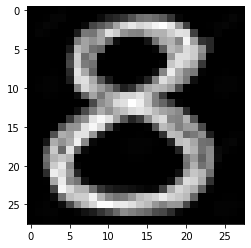

In [21]:
plt.imshow(x.squeeze(-1), cmap="gray")

**Predicciones**

In [22]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 8, Prob: 100.0 %


In [23]:
pred

array([[5.7364814e-21, 1.9471972e-12, 1.3851009e-08, 3.8255514e-09,
        3.1139674e-17, 5.2575305e-13, 3.8652580e-14, 6.0700129e-21,
        1.0000000e+00, 7.2777156e-16]], dtype=float32)



---



In [ ]:
train_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
train, val = random_split(train_data, [55000, 5000])
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)


**Definir el Modelo**

In [ ]:
model = nn.Sequential(
    nn.Linear(28 * 28, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Dropout(0.1), #sobreajuste
    nn.Linear(64, 10) 
)

In [ ]:
model= model
if(torch.cuda.is_available()==True):
    model=model.cuda()
    
optimiser=optim.SGD(model.parameters(),lr=1e-2)
loss=nn.CrossEntropyLoss()

**Definir el Optimizador**

In [ ]:
params = model.parameters()
optimiser = optim.SGD(params, lr=1e-2)

**Definir pérdida**



In [ ]:
loss = nn.CrossEntropyLoss()

**Búcles de entrada**

In [ ]:
nb_epochs = 5
for epoch in range(nb_epochs):
    losses = list()
    accuracies = list()
    model.train()     
    for batch in train_loader: 

        x,y = batch
        b=x.size(0)
        x=x.view(b, -1).cuda()      


        # 1 forward
        l = model(x) # l: logits

        #2 compute the objective function
        J = loss(l,y.cuda())

        # 3 cleaning the gradients
        model.zero_grad()
        # optimiser.zero_grad()
        # params.grad.zero_()

        # 4 accumulate the partial derivatives of J wrt params
        J.backward()

        # 5 step in the opposite direction of the gradient
        optimiser.step()



        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

    print(f'Epoch {epoch + 1}', end=', ')
    print(f'training loss: {torch.tensor(losses).mean():.2f}', end=', ')
    print(f'training accuracy: {torch.tensor(accuracies).mean():.2f}')


    losses = list()
    accuracies = list() 
    model.eval()
    for batch in val_loader: 
        x,y = batch
        b=x.size(0)
        x=x.view(b, -1).cuda()  

        with torch.no_grad(): 
            l = model(x)

        #2 compute the objective function
        J = loss(l,y.cuda())

        losses.append(J.item())
        accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

    print(f'Epoch {epoch + 1}',end=', ')
    print(f'validation loss: {torch.tensor(losses).mean():.2f}', end=', ')
    print(f'validation accuracy: {torch.tensor(accuracies).mean():.2f}')

Epoch 1, training loss: 1.20, training accuracy: 0.67
Epoch 1, validation loss: 0.49, validation accuracy: 0.86
Epoch 2, training loss: 0.44, training accuracy: 0.87
Epoch 2, validation loss: 0.35, validation accuracy: 0.90
Epoch 3, training loss: 0.35, training accuracy: 0.90
Epoch 3, validation loss: 0.29, validation accuracy: 0.91
Epoch 4, training loss: 0.30, training accuracy: 0.91
Epoch 4, validation loss: 0.27, validation accuracy: 0.92
Epoch 5, training loss: 0.27, training accuracy: 0.92
Epoch 5, validation loss: 0.24, validation accuracy: 0.93


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
l.detach()[0]

tensor([-4.0316, -2.0069, -1.9442,  0.5967,  4.8807,  0.5269, -2.5488,  1.5023,
        -0.1358,  3.5515], device='cuda:0')



---



In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse as parser
import sys
import tensorflow as tf

FLAGS = None

def main(_):
  # Import data
  mnist = URL.read_data_sets(FLAGS.data_dir, one_hot=True)

  # Create the model
  x = tf.placeholder(tf.float32, [None, 784])
  W = tf.Variable(tf.zeros([784, 10]))
  b = tf.Variable(tf.zeros([10]))
  y = tf.matmul(x, W) + b

  # Define loss and optimizer
  y_ = tf.placeholder(tf.float32, [None, 10])

  cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
  train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

  sess = tf.InteractiveSession()
  tf.global_variables_initializer().run()
  # Train
  for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

  # Test trained model
  correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  print(sess.run(accuracy, feed_dict={x: mnist.test.images,y_: mnist.test.labels}))

In [ ]:
import torch

In [ ]:
!pip install matplotlib torch torchvision skorch
!pip install cleanlab

In [ ]:
import numpy as np
import torch
import warnings

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784")  # Obtener el conjunto de datos MNIST

X = mnist.data.astype("float32").to_numpy() # Matriz 2D (las imágenes se aplanan en 1D)
X /= 255.0  #Escale las características al rango [0, 1]
X = X.reshape(len(X), 1, 28, 28)  # remodelar en [N, C, H, W] para PyTorch

y = mnist.target.astype("int64").to_numpy()  # matriz 1D de etiquetas

In [ ]:
from torch import nn

class ClassifierModule(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.out = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, X):
        X = self.cnn(X)
        X = self.out(X)
        return X

In [ ]:
from skorch import NeuralNetClassifier

model_skorch = NeuralNetClassifier(ClassifierModule)

In [ ]:
from sklearn.model_selection import cross_val_predict

num_crossval_folds = 3  # por eficiencia; valores como 5 o 10 generalmente funcionarán mejor
pred_probs = cross_val_predict(
    model_skorch,
    X,
    y,
    cv=num_crossval_folds,
    method="predict_proba",
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6908       0.9136        0.3100  6.0705
      2        0.2112       0.9413        0.2003  5.0268
      3        0.1520       0.9516        0.1574  5.0171
      4        0.1240       0.9593        0.1332  6.0064
      5        0.1066       0.9635        0.1179  4.8932
      6        0.0948       0.9667        0.1071  6.1698
      7        0.0860       0.9684        0.0994  4.8204
      8        0.0792       0.9703        0.0934  5.4634
      9        0.0737       0.9721        0.0886  4.9380
     10        0.0691       0.9738        0.0847  5.1463
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7042       0.9249        0.2788  4.9130
      2        0.1907       0.9465        0.1816  5.0624
      3        0.1355       0.9561        0.1475  5.1771
      4        0.1100       0.9

In [ ]:
from sklearn.metrics import accuracy_score

predicted_labels = pred_probs.argmax(axis=1)
acc = accuracy_score(y, predicted_labels)
print(f"Cross-validated estimate of accuracy on held-out data: {acc}")

Cross-validated estimate of accuracy on held-out data: 0.9751428571428571


In [ ]:
from cleanlab.filter import find_label_issues

ranked_label_issues = find_label_issues(
    y,
    pred_probs,
    return_indices_ranked_by="self_confidence",
)

print(f"Cleanlab found {len(ranked_label_issues)} label issues.")
print(f"Top 15 most likely label errors: \n {ranked_label_issues[:15]}")

Cleanlab found 144 label issues.
Top 15 most likely label errors: 
 [59915 24798 19124 53216  2720 59701 50340  7010 16376 23824 44484   500
  8729 31134 32018]


In [ ]:
import matplotlib.pyplot as plt

def plot_examples(id_iter, nrows=1, ncols=1):
    for count, id in enumerate(id_iter):
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(X[id].reshape(28, 28), cmap="gray")
        plt.title(f"id: {id} \n label: {y[id]}")
        plt.axis("off")

    plt.tight_layout(h_pad=2.0)

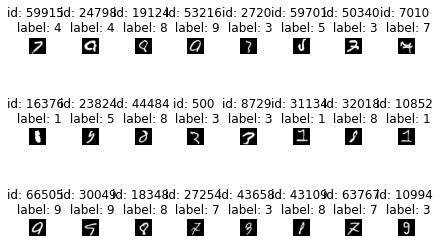

In [ ]:
plot_examples(ranked_label_issues[range(24)], 3, 8)

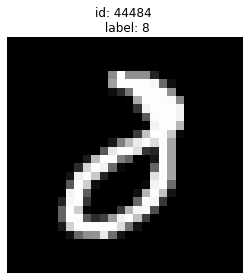

In [ ]:
plot_examples([44484])